# Birr Recognition for Blind person.

### About the Me:
- **Name:** Samuel Abatneh
- **AI Student:** 5th year
- **Student ID:** UGR/7229/12

I am passionate about the intersection of technology and accessibility, and this project reflects my commitment to making a positive impact in the lives of individuals with visual impairments.
## Ethiopian Currency Detection App for Blind Individuals

I am excited to share a project that I have been working on—a currency detection application designed specifically for blind individuals in Ethiopia. This app focuses on the Ethiopian birr and aims to enhance the independence and accessibility of visually impaired users when dealing with currency.

### Key Features:
- **Currency Recognition:** The app uses advanced AI models to accurately recognize Ethiopian birr banknotes.
- **Audio Feedback (Future plan):** To cater to visually impaired users, the app provides clear and concise audio feedback, enabling them to identify the denomination of the currency.
- **User-Friendly Interface (Future plan):** Designed with accessibility in mind, the app features an intuitive and easy-to-navigate interface.

### Purpose:
The primary goal of this application is to empower blind individuals, allowing them to confidently manage and identify Ethiopian birr banknotes on their own. By leveraging AI technology, we aim to contribute to creating a more inclusive and accessible environment.


# Import Necessary Libraries

In [1]:
import numpy as np 
import pandas as pd 
import os
from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms

# Data preproccesing

In [2]:
import shutil
shutil.copytree("/kaggle/input/five-birr", "/kaggle/working/data/five_birr")
shutil.copytree("/kaggle/input/ten-birr", "/kaggle/working/data/ten_birr")
shutil.copytree("/kaggle/input/fifty-birr", "/kaggle/working/data/fifty_birr")
shutil.copytree("/kaggle/input/hundred-birr", "/kaggle/working/data/hundred_birr")
shutil.copytree("/kaggle/input/two-hundred-birr", "/kaggle/working/data/two_hundred_birr")

'/kaggle/working/data/two_hundred_birr'

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
BASE_PATH = '/kaggle/working/data'

In [5]:
image=[]
labels=[]
for file in os.listdir(BASE_PATH):
    if file=='five_birr':
        for c in os.listdir(os.path.join(BASE_PATH, file)):
            if c[-3:] == "jpg":
                image.append(c)
                labels.append('five_birr')
    if file=='ten_birr':
        for c in os.listdir(os.path.join(BASE_PATH, file)):
            if c[-3:] == "jpg":
                image.append(c)
                labels.append('ten_birr')
    if file=='fifty_birr':
        for c in os.listdir(os.path.join(BASE_PATH, file)):
            if c[-3:] == "jpg":
                image.append(c)
                labels.append('fifty_birr')
    if file=='hundred_birr':
        for c in os.listdir(os.path.join(BASE_PATH, file)):
            if c[-3:] == "jpg":
                image.append(c)
                labels.append('hundred_birr')
                
    if file=='two_hundred_birr':
        for c in os.listdir(os.path.join(BASE_PATH, file)):
            if c[-3:] == "jpg":
                image.append(c)
                labels.append('two_hundred_birr')
                
data = {'Images':image, 'labels':labels} 
data = pd.DataFrame(data) 
data.head()

,Images,labels
0,86.jpg,two_hundred_birr
1,119.jpg,two_hundred_birr
2,76.jpg,two_hundred_birr
3,97.jpg,two_hundred_birr
4,41.jpg,two_hundred_birr


# Label Encoding

In [6]:
lb = LabelEncoder()
data['encoded_labels'] = lb.fit_transform(data['labels'])
data.head()

,Images,labels,encoded_labels
0,86.jpg,two_hundred_birr,4
1,119.jpg,two_hundred_birr,4
2,76.jpg,two_hundred_birr,4
3,97.jpg,two_hundred_birr,4
4,41.jpg,two_hundred_birr,4


In [7]:
batch_size = 128
validation_split = .3
shuffle_dataset = True
random_seed= 42

In [8]:
dataset_size = len(data)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:

In [9]:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

In [10]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Prepare the dataset

In [11]:
class Dataset(Dataset):
    def __init__(self, img_data,img_path,transform=None):
        self.img_path = img_path
        self.transform = transform
        self.img_data = img_data
        
    def __len__(self):
        return len(self.img_data)
    
    def __getitem__(self, index):
        img_name = os.path.join(self.img_path,self.img_data.loc[index, 'labels'],
                                self.img_data.loc[index, 'Images'])
        image = Image.open(img_name)
        #image = image.convert('RGB')
        image = image.resize((300,300))
        label = torch.tensor(self.img_data.loc[index, 'encoded_labels'])
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [12]:
dataset = Dataset(data,BASE_PATH,transform)

In [13]:

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler)

In [14]:
def img_display(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    return npimg

# Test the image and the label

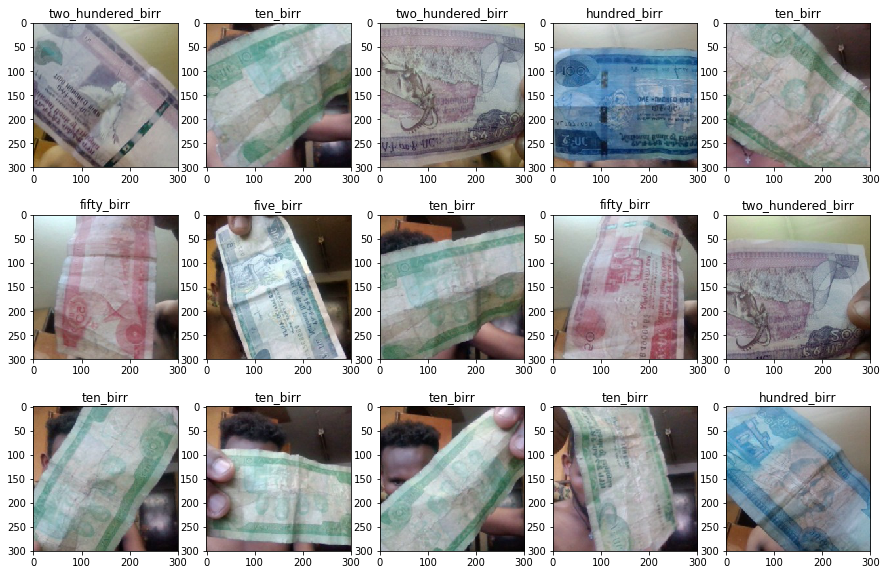

In [34]:
# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
birr_notes = {0: 'fifty_birr', 1: 'five_birr', 2: 'hundred_birr', 3: 'ten_birr', 4: "two_hundered_birr"}
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        ax.imshow(img_display(image)) # add image
        ax.set(title = f"{birr_notes[label.item()]}") # add label

# Define layers for our CNN model

In [16]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 3 input image channel, 16 output channels, 3x3 square convolution kernel
        self.conv1 = nn.Conv2d(3,16,kernel_size=3,stride=2,padding=1)
        self.conv2 = nn.Conv2d(16, 32,kernel_size=3,stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 64,kernel_size=3,stride=2, padding=1)
        self.conv4 = nn.Conv2d(64, 64,kernel_size=3,stride=2, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout2d(0.4)
        self.batchnorm1 = nn.BatchNorm2d(16)
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.batchnorm3 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64*5*5,512 )
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 5)
        
    def forward(self, x):
        x = self.batchnorm1(F.relu(self.conv1(x)))
        x = self.batchnorm2(F.relu(self.conv2(x)))
        x = self.dropout(self.batchnorm2(self.pool(x)))
        x = self.batchnorm3(self.pool(F.relu(self.conv3(x))))
        x = self.dropout(self.conv4(x))
        x = x.view(-1, 64*5*5) # Flatten layer
        x = self.dropout(self.fc1(x))
        x = self.dropout(self.fc2(x))
        x = F.log_softmax(self.fc3(x),dim = 1)
        return x

In [17]:
model = Net()
print(model)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout2d(p=0.4, inplace=False)
  (batchnorm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1600, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=5, bias=True)
)


# CrossEntropyLoss

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [19]:
def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()


# Train My model
n_epoch = 100

In [26]:
n_epochs = 25
print_every = 10
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_loader)
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    # scheduler.step(epoch)
    correct = 0
    total=0
    print(f'Epoch {epoch}\n')
    for batch_idx, (data_, target_) in enumerate(train_loader):
        #data_, target_ = data_.to(device), target_.to(device)# on GPU
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(data_)
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        _,pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        if (batch_idx) % 20 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain loss: {np.mean(train_loss):.4f}, train acc: {(100 * correct / total):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        model.eval()
        for data_t, target_t in (validation_loader):
            #data_t, target_t = data_t.to(device), target_t.to(device)# on GPU
            outputs_t = model(data_t)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t / total_t)
        val_loss.append(batch_loss/len(validation_loader))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t / total_t):.4f}\n')
        # Saving the best weight 
        if network_learned:
            valid_loss_min = batch_loss
            torch.save(model.state_dict(), 'model_classification.pth')
            print('Detected network improvement, saving current model')
    model.train()

Epoch 1

Epoch [1/25], Step [0/4], Loss: 1.6078

train loss: 1.6100, train acc: 19.6162
validation loss: 1.6096, validation acc: 19.5000

Detected network improvement, saving current model
Epoch 2

Epoch [2/25], Step [0/4], Loss: 1.3964

train loss: 1.4961, train acc: 58.6354
validation loss: 1.6108, validation acc: 19.5000

Epoch 3

Epoch [3/25], Step [0/4], Loss: 1.3211

train loss: 1.4169, train acc: 66.7377
validation loss: 1.6124, validation acc: 19.5000

Epoch 4

Epoch [4/25], Step [0/4], Loss: 1.1804

train loss: 1.3288, train acc: 71.6418
validation loss: 1.6266, validation acc: 19.5000

Epoch 5

Epoch [5/25], Step [0/4], Loss: 0.9899

train loss: 1.2343, train acc: 76.5458
validation loss: 1.6667, validation acc: 19.5000

Epoch 6

Epoch [6/25], Step [0/4], Loss: 0.7080

train loss: 1.1417, train acc: 81.4499
validation loss: 1.7298, validation acc: 19.5000

Epoch 7

Epoch [7/25], Step [0/4], Loss: 0.6987

train loss: 1.0556, train acc: 85.9275
validation loss: 1.8058, validati

## Accuracy and loss Curve

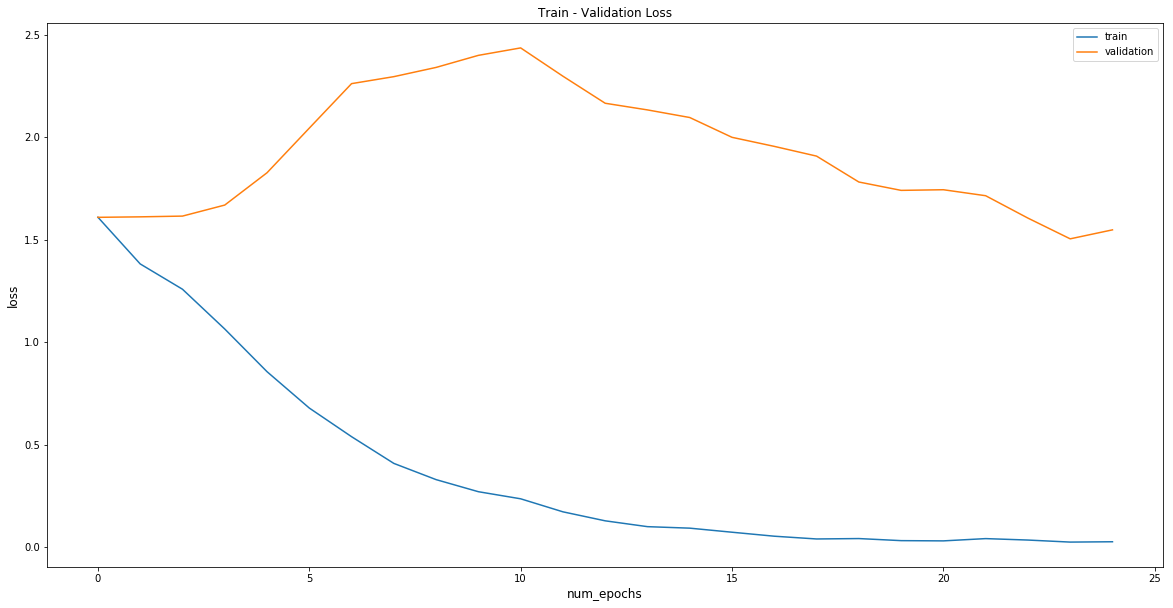

In [27]:
fig = plt.figure(figsize=(20,10))
plt.title("Train - Validation Loss")
plt.plot( train_loss, label='train')
plt.plot( val_loss, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.legend(loc='best')

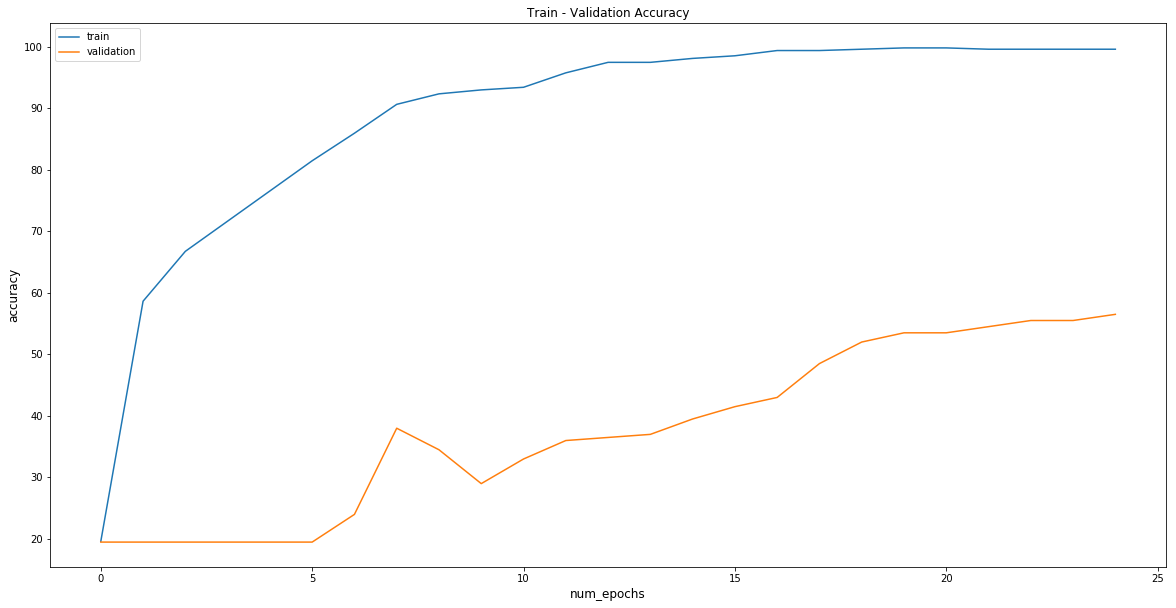

In [28]:
fig = plt.figure(figsize=(20,10))
plt.title("Train - Validation Accuracy")
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')

In [29]:
# Importing trained Network with better loss of validation
model.load_state_dict(torch.load('model_classification.pth'))

<All keys matched successfully>

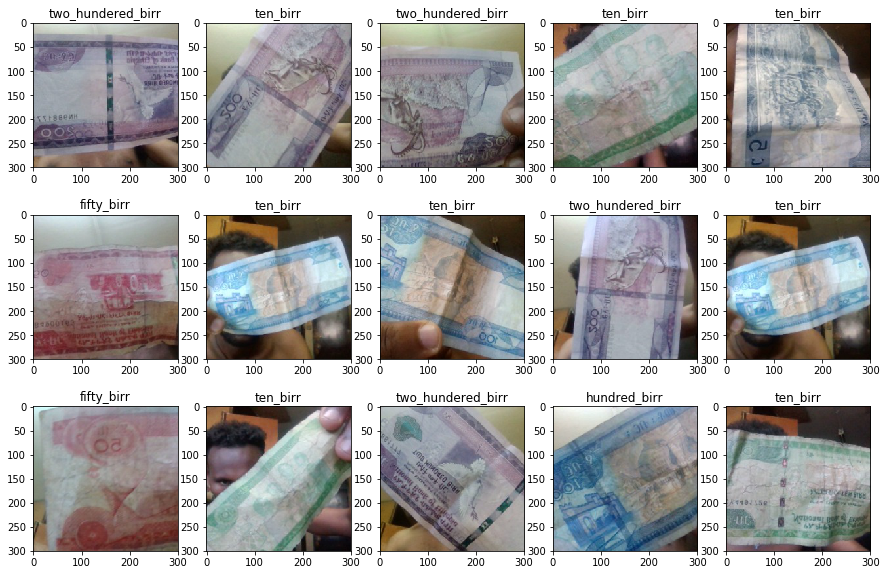

In [39]:

dataiter = iter(validation_loader)
images, labels = dataiter.next()

birr_notes = {0: 'fifty_birr', 1: 'five_birr', 2: 'hundred_birr', 3: 'ten_birr', 4: "two_hundered_birr"}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
with torch.no_grad():
    model.eval()
    for ax, image, label in zip(axis.flat,images, labels):
        ax.imshow(img_display(image)) # add image
        image_tensor = image.unsqueeze_(0)
        output_ = model(image_tensor)
        output_ = output_.argmax()
        ax.set_title(str(birr_notes[output_.item()]))